# Part 1

In [2]:
# !pip install opendatasets, transformers, nltk

In [3]:
import os
import ast
import nltk
import torch
import pandas as pd
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import opendatasets as od
from google.colab import drive
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from torch.utils.data import DataLoader, random_split
from transformers import ViTFeatureExtractor, ViTModel
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
nltk.download('punkt')
od.download("https://www.kaggle.com/datasets/raddar/chest-xrays-indiana-university/data?select=indiana_projections.csv")

In [16]:
df_images = pd.read_csv("/content/chest-xrays-indiana-university/indiana_projections.csv")
df_reports = pd.read_csv("/content/chest-xrays-indiana-university/indiana_reports.csv")

In [17]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
vit_model_name = "google/vit-base-patch16-224"
feature_extractor = ViTFeatureExtractor.from_pretrained(vit_model_name)
vit_model = ViTModel.from_pretrained(vit_model_name)
vit_model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vit_model = vit_model.to(device)

img_filename_col = "filename"
uid_col = "uid"
embeddings_output_csv = "/content/drive/MyDrive/dataMIN/MRI_ViT_embeddings.csv"

embeddings_records = []
embeddings_output_csv

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
for idx, row in tqdm(df_images.iterrows(), total=df_images.shape[0], desc="Processing MRI Images"):
    img_file = row[img_filename_col]
    patient_uid = row[uid_col]
    img_full_path = os.path.join("/content/chest-xrays-indiana-university/images/images_normalized/", img_file)

    image_obj = Image.open(img_full_path).convert("RGB")
    inputs = feature_extractor(images=image_obj, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = vit_model(**inputs)
        cls_embedding = outputs.last_hidden_state[:, 0, :]

    embedding_array = cls_embedding.cpu().numpy().flatten()
    embeddings_records.append({
        "uid": patient_uid,
        "img_path": img_full_path,
        "embedding": embedding_array.tolist()
    })



Processing MRI Images: 100%|██████████| 7466/7466 [15:02<00:00,  8.27it/s]


In [21]:
embeddings_df = pd.DataFrame(embeddings_records)
embeddings_df.to_csv(embeddings_output_csv, index=False)
print(f"Embeddings saved to: {embeddings_output_csv}")

Embeddings saved to: /content/drive/MyDrive/dataMIN/MRI_ViT_embeddings.csv


In [22]:
reports_csv_path = "/content/drive/MyDrive/dataMIN/indiana_reports.csv"
df_reports = pd.read_csv(reports_csv_path)

merged_df = pd.merge(embeddings_df, df_reports, on="uid", how="inner")
merged_df = merged_df.dropna(subset=['findings'])
print(merged_df.head())


   uid                                           img_path  \
0    1  /content/chest-xrays-indiana-university/images...   
1    1  /content/chest-xrays-indiana-university/images...   
2    2  /content/chest-xrays-indiana-university/images...   
3    2  /content/chest-xrays-indiana-university/images...   
6    4  /content/chest-xrays-indiana-university/images...   

                                           embedding  \
0  [-0.10488208383321762, 0.6710492372512817, -0....   
1  [-0.6065076589584351, 0.7736474871635437, -0.3...   
2  [-0.02375771291553974, 0.3476196825504303, -0....   
3  [-0.04026693105697632, -0.2917379140853882, -0...   
6  [-0.1743493378162384, 0.5614907145500183, -0.9...   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6  Pulmonary Dis

In [23]:
class MedicalMRIDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.df = df
        self.embeddings = df["embedding"].values
        self.texts = df["findings"].values
        self.image_paths = df["img_path"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        emb = self.embeddings[index]
        if isinstance(emb, str):
            emb = ast.literal_eval(emb)
        return {
            "embedding": torch.tensor(emb, dtype=torch.float32),
            "text": self.texts[index],
            "img_path": self.image_paths[index]
        }


In [24]:
dataset = MedicalMRIDataset(merged_df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

checkpoints_dir = "/content/drive/MyDrive/dataMIN/model_checkpoints"
os.makedirs(checkpoints_dir, exist_ok=True)


In [25]:
def compute_bleu_score(reference, hypothesis):
    ref_tokens = [reference.split()]
    hyp_tokens = hypothesis.split()
    return sentence_bleu(ref_tokens, hyp_tokens)

def save_model_checkpoint(model_obj, mlp_obj, optimizer_obj, epoch_num, step_num, avg_loss_val, avg_bleu_val):
    checkpoint_dict = {
        "model_state_dict": model_obj.state_dict(),
        "mlp_state_dict": mlp_obj.state_dict(),
        "optimizer_state_dict": optimizer_obj.state_dict(),
        "epoch": epoch_num,
        "step": step_num,
        "avg_loss": avg_loss_val,
        "avg_bleu": avg_bleu_val
    }
    save_path = os.path.join(checkpoints_dir, f"checkpoint_epoch{epoch_num}_step{step_num}.pth")
    torch.save(checkpoint_dict, save_path)
    print(f"Checkpoint saved at {save_path}")


In [26]:
text_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
text_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
image_embedding_dim = 768
gpt2_embed_dim = text_model.config.n_embd
text_tokenizer.pad_token = text_tokenizer.eos_token

if image_embedding_dim != gpt2_embed_dim:
    mapping_mlp = nn.Sequential(
        nn.Linear(image_embedding_dim, gpt2_embed_dim),
        nn.ReLU()
    ).to(device)
else:
    mapping_mlp = nn.Identity().to(device)

print(merged_df.head())

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

   uid                                           img_path  \
0    1  /content/chest-xrays-indiana-university/images...   
1    1  /content/chest-xrays-indiana-university/images...   
2    2  /content/chest-xrays-indiana-university/images...   
3    2  /content/chest-xrays-indiana-university/images...   
6    4  /content/chest-xrays-indiana-university/images...   

                                           embedding  \
0  [-0.10488208383321762, 0.6710492372512817, -0....   
1  [-0.6065076589584351, 0.7736474871635437, -0.3...   
2  [-0.02375771291553974, 0.3476196825504303, -0....   
3  [-0.04026693105697632, -0.2917379140853882, -0...   
6  [-0.1743493378162384, 0.5614907145500183, -0.9...   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
6  Pulmonary Dis

In [27]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

In [ ]:
def evaluate_model(text_model, loader, text_tokenizer, device):
    text_model.eval()
    total_loss = 0
    total_bleu = 0

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating"):
            texts_batch = batch['text']
            inputs = text_tokenizer(
                texts_batch,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to(device)
            input_ids = inputs['input_ids']
            attention_mask = inputs['attention_mask']

            outputs = text_model(input_ids, attention_mask=attention_mask, labels=input_ids)
            loss_val = outputs.loss
            total_loss += loss_val.item()

            predicted_tokens = text_tokenizer.decode(input_ids[0], skip_special_tokens=True)
            bleu_val = compute_bleu_score(texts_batch[0], predicted_tokens)
            total_bleu += bleu_val

    avg_loss = total_loss / len(loader)
    avg_bleu = total_bleu / len(loader)
    print(f"Test Loss: {avg_loss:.4f}, Avg BLEU: {avg_bleu:.4f}")
    return avg_loss, avg_bleu


In [ ]:
def train_epoch(text_model, mapping_mlp, loader, optimizer, epoch, save_dir, text_tokenizer, device, test_loader=None):
    text_model.train()
    total_loss = 0
    total_bleu = 0

    for batch_idx, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch+1}", dynamic_ncols=True)):
        texts_batch = batch['text']
        inputs = text_tokenizer(
            texts_batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']

        outputs = text_model(input_ids, attention_mask=attention_mask, labels=input_ids)
        loss_val = outputs.loss
        total_loss += loss_val.item()

        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        predicted_tokens = text_tokenizer.decode(input_ids[0], skip_special_tokens=True)
        bleu_val = compute_bleu_score(texts_batch[0], predicted_tokens)
        total_bleu += bleu_val

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(loader)}, Loss: {loss_val.item():.4f}")

    avg_loss = total_loss / len(loader)
    avg_bleu = total_bleu / len(loader)
    print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}, Avg BLEU: {avg_bleu:.4f}")

    if test_loader is not None:
        evaluate_model(text_model, test_loader, text_tokenizer, device)

    checkpoint_path = os.path.join(save_dir, "checkpoint_latest.pth")
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': text_model.state_dict(),
        'mlp_state_dict': mapping_mlp.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
        'bleu_score': avg_bleu
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

In [28]:
num_epochs = 5
optimizer = AdamW(list(text_model.parameters()) + list(mapping_mlp.parameters()), lr=5e-5)
criterion = nn.CrossEntropyLoss() 

for ep in range(num_epochs):
    train_epoch(text_model, mapping_mlp, train_loader, optimizer, ep, checkpoints_dir, text_tokenizer, device, test_loader=test_loader)

checkpoint_path = "/content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)

text_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device)
text_model.load_state_dict(checkpoint['model_state_dict'])

if image_embedding_dim != gpt2_embed_dim:
    mapping_mlp = nn.Sequential(
        nn.Linear(image_embedding_dim, gpt2_embed_dim),
        nn.ReLU()
    ).to(device)
else:
    mapping_mlp = nn.Identity().to(device)
mapping_mlp.load_state_dict(checkpoint['mlp_state_dict'])

/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1:   0%|          | 2/647 [00:01<05:53,  1.82it/s]

Epoch 1, Batch 0/647, Loss: 6.0658


Epoch 1:  16%|█▌        | 101/647 [00:22<01:52,  4.84it/s]

Epoch 1, Batch 100/647, Loss: 1.1764


Epoch 1:  31%|███       | 201/647 [00:44<01:32,  4.82it/s]

Epoch 1, Batch 200/647, Loss: 1.1529


Epoch 1:  47%|████▋     | 301/647 [01:05<01:12,  4.80it/s]

Epoch 1, Batch 300/647, Loss: 0.7411


Epoch 1:  62%|██████▏   | 401/647 [01:27<00:51,  4.76it/s]

Epoch 1, Batch 400/647, Loss: 1.1779


Epoch 1:  77%|███████▋  | 501/647 [01:48<00:30,  4.87it/s]

Epoch 1, Batch 500/647, Loss: 0.8431


Epoch 1:  93%|█████████▎| 602/647 [02:10<00:08,  5.46it/s]

Epoch 1, Batch 600/647, Loss: 0.9780


Epoch 1: 100%|██████████| 647/647 [02:20<00:00,  4.62it/s]


Epoch 1 completed, Avg Loss: 1.0318, Avg BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:10<00:00, 16.20it/s]


Test Loss: 0.7129, Avg BLEU: 1.0000
Checkpoint saved at /content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth


Epoch 2:   0%|          | 2/647 [00:00<02:18,  4.67it/s]

Epoch 2, Batch 0/647, Loss: 0.4694


Epoch 2:  16%|█▌        | 101/647 [00:21<01:54,  4.78it/s]

Epoch 2, Batch 100/647, Loss: 0.6714


Epoch 2:  31%|███       | 201/647 [00:43<01:32,  4.84it/s]

Epoch 2, Batch 200/647, Loss: 0.8409


Epoch 2:  47%|████▋     | 301/647 [01:04<01:13,  4.72it/s]

Epoch 2, Batch 300/647, Loss: 0.5262


Epoch 2:  62%|██████▏   | 401/647 [01:26<00:50,  4.86it/s]

Epoch 2, Batch 400/647, Loss: 0.9404


Epoch 2:  77%|███████▋  | 501/647 [01:47<00:30,  4.79it/s]

Epoch 2, Batch 500/647, Loss: 0.5958


Epoch 2:  93%|█████████▎| 602/647 [02:09<00:08,  5.44it/s]

Epoch 2, Batch 600/647, Loss: 0.7147


Epoch 2: 100%|██████████| 647/647 [02:18<00:00,  4.65it/s]


Epoch 2 completed, Avg Loss: 0.6908, Avg BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:09<00:00, 16.22it/s]


Test Loss: 0.5982, Avg BLEU: 1.0000
Checkpoint saved at /content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth


Epoch 3:   0%|          | 2/647 [00:00<02:17,  4.68it/s]

Epoch 3, Batch 0/647, Loss: 0.3148


Epoch 3:  16%|█▌        | 101/647 [00:21<01:56,  4.69it/s]

Epoch 3, Batch 100/647, Loss: 0.5789


Epoch 3:  31%|███       | 201/647 [00:43<01:32,  4.83it/s]

Epoch 3, Batch 200/647, Loss: 0.7258


Epoch 3:  47%|████▋     | 301/647 [01:04<01:13,  4.69it/s]

Epoch 3, Batch 300/647, Loss: 0.4675


Epoch 3:  62%|██████▏   | 401/647 [01:26<00:50,  4.87it/s]

Epoch 3, Batch 400/647, Loss: 0.7956


Epoch 3:  77%|███████▋  | 501/647 [01:47<00:30,  4.75it/s]

Epoch 3, Batch 500/647, Loss: 0.5237


Epoch 3:  93%|█████████▎| 602/647 [02:09<00:08,  5.45it/s]

Epoch 3, Batch 600/647, Loss: 0.6103


Epoch 3: 100%|██████████| 647/647 [02:18<00:00,  4.66it/s]


Epoch 3 completed, Avg Loss: 0.5847, Avg BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:10<00:00, 16.01it/s]


Test Loss: 0.5339, Avg BLEU: 1.0000
Checkpoint saved at /content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth


Epoch 4:   0%|          | 2/647 [00:00<02:20,  4.58it/s]

Epoch 4, Batch 0/647, Loss: 0.2708


Epoch 4:  16%|█▌        | 101/647 [00:21<01:49,  4.98it/s]

Epoch 4, Batch 100/647, Loss: 0.4991


Epoch 4:  31%|███       | 201/647 [00:43<01:33,  4.79it/s]

Epoch 4, Batch 200/647, Loss: 0.6063


Epoch 4:  47%|████▋     | 301/647 [01:04<01:12,  4.79it/s]

Epoch 4, Batch 300/647, Loss: 0.3930


Epoch 4:  62%|██████▏   | 401/647 [01:26<00:51,  4.82it/s]

Epoch 4, Batch 400/647, Loss: 0.7051


Epoch 4:  77%|███████▋  | 501/647 [01:47<00:30,  4.86it/s]

Epoch 4, Batch 500/647, Loss: 0.4116


Epoch 4:  93%|█████████▎| 602/647 [02:09<00:08,  5.42it/s]

Epoch 4, Batch 600/647, Loss: 0.5041


Epoch 4: 100%|██████████| 647/647 [02:18<00:00,  4.66it/s]


Epoch 4 completed, Avg Loss: 0.5102, Avg BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:10<00:00, 15.97it/s]


Test Loss: 0.4893, Avg BLEU: 1.0000
Checkpoint saved at /content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth


Epoch 5:   0%|          | 2/647 [00:00<02:14,  4.80it/s]

Epoch 5, Batch 0/647, Loss: 0.2544


Epoch 5:  16%|█▌        | 101/647 [00:21<01:49,  4.98it/s]

Epoch 5, Batch 100/647, Loss: 0.4702


Epoch 5:  31%|███       | 201/647 [00:43<01:34,  4.73it/s]

Epoch 5, Batch 200/647, Loss: 0.5529


Epoch 5:  47%|████▋     | 301/647 [01:04<01:12,  4.79it/s]

Epoch 5, Batch 300/647, Loss: 0.3061


Epoch 5:  62%|██████▏   | 401/647 [01:26<00:51,  4.77it/s]

Epoch 5, Batch 400/647, Loss: 0.6204


Epoch 5:  77%|███████▋  | 501/647 [01:47<00:30,  4.85it/s]

Epoch 5, Batch 500/647, Loss: 0.3855


Epoch 5:  93%|█████████▎| 602/647 [02:08<00:08,  5.38it/s]

Epoch 5, Batch 600/647, Loss: 0.4159


Epoch 5: 100%|██████████| 647/647 [02:18<00:00,  4.67it/s]


Epoch 5 completed, Avg Loss: 0.4515, Avg BLEU: 1.0000


Evaluating: 100%|██████████| 162/162 [00:10<00:00, 15.94it/s]


Test Loss: 0.4620, Avg BLEU: 1.0000
Checkpoint saved at /content/drive/MyDrive/dataMIN/model_checkpoints/checkpoint_latest.pth


<ipython-input-28-9a5646b4a819>:102: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


<All keys matched successfully>

<ipython-input-29-97bbea9a03a5>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  transformed_emb = mapping_mlp(torch.tensor(emb_vector, dtype=torch.float32).to(device))


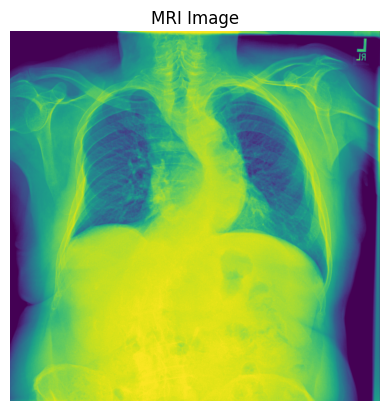

Image Path: /content/chest-xrays-indiana-university/images/images_normalized/484_IM-2108-1001.dcm.png
Original Report: The heart is normal in size. The mediastinum is stable. There is again significant thoracolumbar rotatory scoliosis. The aorta is atherosclerotic. The lungs are hypoinflated but clear.
Generated Report:  heart size is normal. The mediastinal contour is within normal limits. The lungs are free of any focal infiltrates. There are no nodules or masses. No visible pneumothorax. No visible pleural fluid. The XXXX are grossly normal. There is no visible free intraperitoneal air under the diaphragm.


In [29]:
test_gen_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

def generate_text_from_embedding(emb_vector, text_model, mapping_mlp, text_tokenizer, max_len=50):
    text_model.eval()
    mapping_mlp.eval()
    transformed_emb = mapping_mlp(torch.tensor(emb_vector, dtype=torch.float32).to(device))
    transformed_emb = transformed_emb.unsqueeze(0)
    input_ids = torch.full((1, 1), text_tokenizer.bos_token_id, dtype=torch.long).to(device)

    with torch.no_grad():
        for _ in range(max_len):
            outputs = text_model(input_ids=input_ids, use_cache=True)
            logits = outputs.logits[:, -1, :]
            next_token_id = torch.argmax(logits, dim=-1)
            input_ids = torch.cat([input_ids, next_token_id.unsqueeze(-1)], dim=-1)
            if next_token_id.item() == text_tokenizer.eos_token_id:
                break

    generated = text_tokenizer.decode(input_ids.squeeze(), skip_special_tokens=True)
    return generated
for idx, batch in enumerate(test_gen_loader):
    emb_sample = batch["embedding"][0]
    true_text = batch["text"][0]
    img_path_sample = batch["img_path"][0]

    gen_text = generate_text_from_embedding(emb_sample, text_model, mapping_mlp, text_tokenizer, max_len=100)
    image_sample = Image.open(img_path_sample)
    plt.imshow(image_sample)
    plt.axis('off')
    plt.title("MRI Image")
    plt.show()

    print(f"Image Path: {img_path_sample}")
    print(f"Original Report: {true_text}")
    print(f"Generated Report: {gen_text}")
    print("=" * 50)
    if idx == 0:
        break

### **Automated Medical Report**


Medical professionals analyze **X-ray images** to diagnose conditions and generate detailed reports. However, **manual interpretation is time-consuming**, leading to potential delays in patient care. This project aims to **automate medical report generation** using **deep learning**, specifically a **Vision Transformer (ViT) encoder** for image feature extraction and **GPT-2** for text generation.


#### **Model Architecture**
To generate medical reports from X-ray images, a **multi-modal deep learning model** was implemented using **Transformer-based architectures**:
1. **Image Encoder**: A **Vision Transformer (ViT)** extracts important features from X-ray images.
2. **Text Decoder**: A **GPT-2 language model** generates descriptive medical reports.
3. **Cross-Attention Mechanism**: This ensures that the decoder aligns the generated text with the extracted image features.




#### **Implementation Details**
- **Libraries Used**: PyTorch, Transformers, Pandas, Matplotlib, and NLTK.
- **Data Loading**:
  - The images and reports were loaded using `pandas` from CSV files.
  - Image preprocessing included **resizing and normalization** for compatibility with ViT.
- **Training Process**:
  - The model was trained on pairs of **X-ray images and their corresponding reports**.
  - Loss was optimized using **AdamW**.
  - The dataset was split into **training and validation sets**.



#### **Evaluation Metrics**
To assess the **quality of the generated reports**, **text similarity metrics** were used:
- **BLEU Score**: Measures the similarity between generated and actual reports.
- **ROUGE-L Score**: Evaluates how well key phrases match between generated and real reports.

Higher scores indicate that the generated reports closely match the expert-written reports.
